# Classify Users Using Random Forest

### Imports and Setup

In [ ]:
# Imports
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import top_k_accuracy_score
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# HugginFace datasets library (~600,000 rows)
DATASET_URL = "hf://datasets/dejanseo/mouse_movement_tracking/mouse.parquet"

### Data Augmentation

In [3]:
def split_sessions(df: pd.DataFrame, n_chunks: int = 5, min_chunk_len: int = 30) -> pd.DataFrame:
    """
    Splits each session into n_chunks, each with at least min_chunk_length data points.
    Discards sessions where any chunk would be too short.
    """
    all_chunks: list[pd.DataFrame] = []

    for session_id, group in df.groupby('session_id'):
        group = group.sort_values('timestamp').reset_index(drop=True)
        total_points = len(group)
        chunk_size = total_points // n_chunks
        if chunk_size < min_chunk_len:
            continue
        valid = True
        for i in range(n_chunks):
            start = i * chunk_size
            end = (i + 1) * chunk_size if i < n_chunks - 1 else total_points
            if (end - start) < min_chunk_len:
                valid = False
                break
        if not valid:
            continue
        for i in range(n_chunks):
            chunk_start = i * chunk_size
            chunk_end = (i + 1) * chunk_size if i < n_chunks - 1 else total_points
            sub = group.iloc[chunk_start:chunk_end].copy()
            sub['original_session_id'] = session_id
            sub['sub_session_id'] = f"{session_id}_{i}"
            all_chunks.append(sub)

    final_df = pd.concat(all_chunks, ignore_index=True).reset_index(drop=True)

    print(f"Data Augmentation Complete - Split into {len(all_chunks)} chunks from {len(df)} original sessions.")

    return final_df

### Feature Engineering and Helper Functions

In [5]:
def session_direction_entropy(angles, n_bins=8):
    """
    Calculate the Shannon entropy of the angles
    i.e. discretize the angles into bins and computes the entropy

    NOTES:
    Shannon entropy is a measure of uncertainty or randomness in the data.
    In this case, it quantifies the diversity of angles in the session.
    For example, a session with a lot of different angles (i.e., a lot of different directions) will have high entropy,
    while a session with very few angles (i.e., mostly straight lines) will have low entropy.
    """
    hist, _ = np.histogram(angles, bins=n_bins, range=(-math.pi, math.pi), density=True)
    hist = hist + 1e-8
    return -np.sum(hist * np.log(hist))

def straightness_ratio(session):
    """
    Calculate the straightness ratio of a session.
    The straightness ratio is defined as the Euclidean distance between the start and end points of the session,
    divided by the total path length of the session.
    In other words, it measures how "straight" the path is.
    """
    start = session.iloc[0][["x", "y"]]
    end = session.iloc[-1][["x", "y"]]
    euclidean = np.linalg.norm(end - start)
    path = session["distance"].sum()
    return euclidean / path if path > 0 else 0

In [7]:
def extract_classifier_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute session-level behavioral statistics features from mouse movement data.
    """

    # Ensure point-level features
    df = df.sort_values(['sub_session_id', 'timestamp'])
    # Compute deltas
    df['dx'] = df['x'].diff().fillna(0)
    df['dy'] = df['y'].diff().fillna(0)
    df['distance'] = np.hypot(df['dx'], df['dy'])
    df['time_delta'] = df['timestamp'].diff().fillna(0)
    # Speed
    df['speed'] = df['distance'] / df['time_delta'].replace(0, np.nan)
    df['speed'] = df['speed'].fillna(0)
    # Angle
    df['angle'] = np.arctan2(df['dy'], df['dx']).fillna(0)
    # Pause and click flags
    df['is_pause'] = (df['time_delta'] > 500).astype(int)
    df['click_event'] = (df['type'] == 'click').astype(int)

    # grouping by session_id to process each session individually
    # each group contains all the mouse events (rows) for a single session
    session_features = df.groupby("sub_session_id").agg({
        "speed": ["mean", "std", "max", "min"],
        "distance": ["mean", "std", "sum"],
        "dx": ["mean", "std"],
        "dy": ["mean", "std"],
        "x": ["mean", "std"],
        "y": ["mean", "std"],
        "time_delta": ["mean", "std", "sum"],
    })

    # flattening columns
    session_features.columns = ['_'.join(col) for col in session_features.columns]
    session_features.reset_index(inplace=True)

    ## directional and angular features
    # goal: caputuring the style/flow of how a person moves their cursor

    # calculating angle of the movement between two mouse points
    # Does the user tend to move in curves? straight lines? suddent directional changes?
    df["angle"] = np.arctan2(df["dy"], df["dx"])

    # calculating the change in angle from one point to the next
    df["angle_diff"] = df["angle"].diff().abs()

    # session-level angular stats
    angle_features = df.groupby("sub_session_id").agg({
        "angle_diff": ["mean", "std", "max"]
    })
    angle_features.columns = ['_'.join(col) for col in angle_features.columns]
    angle_features.reset_index(inplace=True)

    ## accleration features
    df["acceleration"] = df["speed"].diff() / df["time_delta"]

    # pause/idle behavior
    # Define a pause as time_delta > threshold (set to 500ms)
    df["is_pause"] = df["time_delta"] > 500

    pause_features = df.groupby("sub_session_id")["is_pause"].sum().reset_index()
    pause_features.rename(columns={"is_pause": "num_pauses"}, inplace=True)

    # normalize x and y based on screen size
    df["x_norm"] = df["x"] / df["screen_width"]
    df["y_norm"] = df["y"] / df["screen_height"]

    # tracking directional tendencies
    direction_features = df.groupby("sub_session_id").agg({
        "x_norm": ["mean", "std"],
        "y_norm": ["mean", "std"]
    })
    direction_features.columns = ['_'.join(col) for col in direction_features.columns]
    direction_features.reset_index(inplace=True)

    # Straightness: Apply the straightness function to each session
    df["straightness"] = df.groupby("sub_session_id", group_keys=False).apply(straightness_ratio).reset_index(drop=True)
    straightness_features = df.groupby("sub_session_id")["straightness"].mean().reset_index()

    # Hesitation time before clicks
    df["hesitation_time"] = df["time_delta"].where(df["type"] == "click")
    hesitation_features = df.groupby("sub_session_id")["hesitation_time"].mean().reset_index()

    # Defining hover as staying within a small radius for a duration
    HOVER_RADIUS = 10  # pixels
    HOVER_TIME_THRESHOLD = 500  # ms

    df["within_hover_radius"] = df["distance"] < HOVER_RADIUS
    df["hover_candidate"] = (df["within_hover_radius"]) & (df["time_delta"] > HOVER_TIME_THRESHOLD)

    hover_counts = df.groupby("sub_session_id")["hover_candidate"].sum().reset_index()
    hover_counts.rename(columns={"hover_candidate": "num_hovers"}, inplace=True)

    # Defining jitter as small erratic changes
    df["is_jitter"] = df["distance"] < 3
    jitter_counts = df.groupby("sub_session_id")["is_jitter"].sum().reset_index()
    jitter_counts.rename(columns={"is_jitter": "jitter_count"}, inplace=True)

    ## Speed quantile ratio, direction entropy, pause ratio, and click ratio
    speedp10 = df.groupby("sub_session_id")["speed"].quantile(0.1).rename("speed_p10")  # 10th percentile
    speedp90 = df.groupby("sub_session_id")["speed"].quantile(0.9).rename("speed_p90")  # 90th percentile
    angles = df.groupby("sub_session_id")["angle"].apply(list).rename("angles")  # list of angles
    total_time = df.groupby("sub_session_id")["time_delta"].sum().rename("total_time")  # total time spent
    pause_time = df.groupby("sub_session_id")["time_delta"].apply(lambda x: x[x > 500].sum()).rename("pause_time")  # total pause time

    # Derive features
    speed_quantile_ratio = (speedp90 / (speedp10 + 1e-8)).rename("speed_quantile_ratio").reset_index()
    direction_entropy = angles.apply(session_direction_entropy)  # Shannon entropy of angles
    # direction entropy normalized by the number of points in the session
    direction_entropy = direction_entropy / (df.groupby("sub_session_id")["angle"].count() + 1e-8)
    direction_entropy = direction_entropy.rename("direction_entropy").reset_index()  # reset index to match the session_id
    pause_ratio = (pause_time / (total_time + 1e-8)).rename("pause_ratio").reset_index()  # ratio of pause time to total time
    # click_rate = (df.groupby("sub_session_id")["click_event"].sum() / (total_time + 1e-8)).rename("click_rate")  # click rate

    #merge into a single-session level dataframe for modeling
    final_df = session_features.copy()
    final_df = final_df.merge(
            angle_features, on='sub_session_id', how='left'
        ).merge(
            pause_features, on='sub_session_id', how='left'
        ).merge(
            direction_features, on='sub_session_id', how='left'
        ).merge(
            straightness_features, on='sub_session_id', how='left'
        ).merge(
            hesitation_features, on='sub_session_id', how='left'
        ).merge(
            hover_counts, on='sub_session_id', how='left'
        ).merge(
            jitter_counts, on='sub_session_id', how='left'
        ).merge(
            speed_quantile_ratio, on='sub_session_id', how='left'
        ).merge(
            direction_entropy, on='sub_session_id', how='left'
        ).merge(
            pause_ratio, on='sub_session_id', how='left'
        )

    final_df.reset_index(drop=True, inplace=True)

    # bring in original label
    mapping = df[['sub_session_id', 'original_session_id']].drop_duplicates()
    final_df = final_df.merge(mapping, on='sub_session_id', how='left')
    final_df = final_df.fillna(0)

    return final_df

### Main Driver Code

#### Loading and Preprocessing Data

In [8]:
# Load Dataset
df = pd.read_parquet(DATASET_URL)

In [9]:
# Load raw data and compute dx, dy, time_delta
df['time_delta'] = df['timestamp'].diff().fillna(0)

# Data augmentation: split sessions into n_chunks
df_aug = split_sessions(df, n_chunks=5, min_chunk_len=50)

sub_session_counts = df_aug.groupby("sub_session_id").size().reset_index(name="row_count")
print(sub_session_counts)

Data Augmentation Complete - Split into 2830 chunks from 685529 original sessions.
                        sub_session_id  row_count
0     session_1740749591318_8meh9m5x_0        104
1     session_1740749591318_8meh9m5x_1        104
2     session_1740749591318_8meh9m5x_2        104
3     session_1740749591318_8meh9m5x_3        104
4     session_1740749591318_8meh9m5x_4        105
...                                ...        ...
2825  session_1741996590105_svrfy0p4_0         63
2826  session_1741996590105_svrfy0p4_1         63
2827  session_1741996590105_svrfy0p4_2         63
2828  session_1741996590105_svrfy0p4_3         63
2829  session_1741996590105_svrfy0p4_4         67

[2830 rows x 2 columns]


#### Feature Engineering and Data Filtration

In [10]:
# Extract features
features = extract_classifier_features(df_aug)

In [11]:
# Data filtration: Drop sessions with less than 5 data points
valid_users = features['original_session_id'].value_counts()
valid_users = valid_users[valid_users >= 5].index
features = features[features['original_session_id'].isin(valid_users)].copy()

#### Data Training/Testing Split and Setup

In [12]:
# Prepare training X and y
X = features.drop(columns=['original_session_id', 'sub_session_id'])
y = features['original_session_id']
# print(X.shape)
# print(y.shape)

# Encode user-ids
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
# print(f"Train labels: {Counter(y_train)}, Test labels: {Counter(y_test)}")

Train size: (2264, 33), Test size: (566, 33)


#### Model Training with Automated Hyperparameter Tuning

In [13]:
## Random Forest with GridSearch on accuracy
# n_estimators is number of trees in the forest and max_depth is the maximum depth of the tree (to prevent overfitting)
# Random Forest is a good choice for this type of data as it can handle non-linear relationships and interactions between features
# It also provides feature importance which can be useful for understanding the data
param_grid = {'n_estimators':[100,200], 'max_depth':[None,10,20]}

# Random Forest Classifier
# GridSearchCV allows us to search for the best hyperparameters using cross-validation
# cv=5 means we will use 5-fold cross-validation to evaluate the model (i.e. split data into 5 parts: train on 4 and test on 1, repeat for each part)
rf_cv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc')
rf_cv.fit(X_train, y_train)  # fit the model to the training data (X_train, y_train)
print("Best params:", rf_cv.best_params_)  # print the best hyperparameters found by GridSearchCV (if used)

C:\Users\MROUIE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\MROUIE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\MROUIE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\MROUIE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\MROUIE\AppData\Local\Programs\Python\Python310\l

Best params: {'max_depth': None, 'n_estimators': 100}


#### Classifier Performance Evaluation and Visualization

In [14]:
# Performance evaluation
preds = rf_cv.predict(X_test)  # predict the labels for the test data (X_test)
proba = rf_cv.predict_proba(X_test)  # predict the probabilities for the test data (X_test)
print(classification_report(y_test, preds))  # classification report (precision, recall, f1-score) for the test data
print("ROC AUC:", roc_auc_score(y_test, proba, multi_class='ovr', average='macro'))  # ROC AUC score for the test data (how well the model can distinguish between classes)

# for i, label in enumerate(le.classes_):
#     print(f"User {label}: {Counter(y_test)[i]} samples")

C:\Users\MROUIE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MROUIE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MROUIE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.50      1.00      0.67         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00    

In [15]:
# Top-k accuracy score
for k in [1, 3, 5, 10]:
    top_k_acc = top_k_accuracy_score(y_test, proba, k=k)
    print(f"Top-{k} accuracy: {top_k_acc:.4f}")

Top-1 accuracy: 0.2668
Top-3 accuracy: 0.3816
Top-5 accuracy: 0.4452
Top-10 accuracy: 0.5088


In [16]:
# Confusion matrix to see how many true positives, false positives, true negatives, and false negatives we have
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [17]:
# Apply t-SNE to reduce dimensionality to 2D for visualization
# t-SNE is a non-linear dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data
# It works by converting the high-dimensional data into a probability distribution and then trying to find a low-dimensional representation that preserves the pairwise similarities as much as possible
X_embedded = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42).fit_transform(X_test)

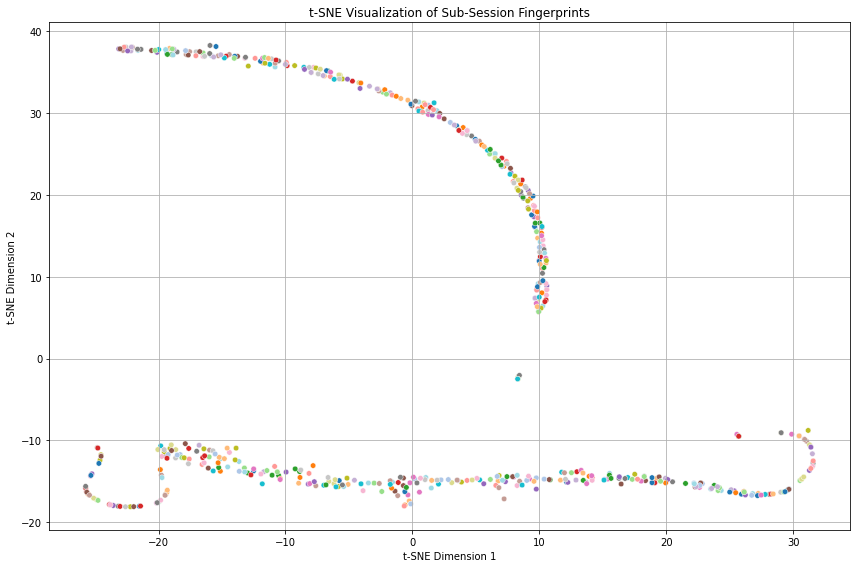

In [18]:
# Plot t-SNE results using seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_test, palette='tab20', s=30, legend=None)
plt.title("t-SNE Visualization of Sub-Session Fingerprints")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()